# 1.Adaboost 算法

基于单层决策树构建弱分类器

In [1]:
import pandas as pd
import numpy as np

In [2]:
#获取特征矩阵和标签矩阵
def get_Mat1():
    xMat = np.mat([[1., 2.1],
                  [1.5, 1.6],
                  [1.3, 1.0],
                  [1.0, 1.0],
                  [2.0, 1.0]])
    yMat = np.mat([1.0,1.0,-1.0,-1.0,1.0]).T
    return xMat, yMat

In [3]:
xMat, yMat = get1_Mat()

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['simhei']
%matplotlib inline

In [5]:
"""
函数功能：单层决策树分类函数
参数说明：
        xMat：特征矩阵
        i： 第i列，也就是第几个特征
        Q：阈值
        S：标志
返回：
        re：分类结果
"""
def Classify0(xMat,i, Q, S):
    re  = np.ones((xMat.shape[0],1))                  #初始化re为1
    if S == 'lt':
        re[xMat[:,i] <= Q] = -1                    #如果小于阈值，则为-1
    else:
        re[xMat[:,i] > Q] = -1                      #如果大于阈值，则为-1
    return re

构建第二个函数寻找最佳单层决策树

In [6]:
"""
函数功能：找到数据集上最佳单层决策树
参数说明：
        xMat: 特征矩阵
        yMat: 标签矩阵
        D： 样本权重
返回：
        bestStump:最佳单层决策树信息
        minE：最小误差
        bestClas:最佳的分类结果
"""
def get_Stump(xMat, yMat,D):
    m,n = xMat.shape                          #m为样本个数，n为特征数
    Steps = 10                                #初始化一个步数
    bestStump = {}                            #用字典形式来存储树桩信息
    bestClas = np.mat(np.zeros((m,1)))        #初始化分类结果为1
    minE = np.inf                             #最小误差初始化为正无穷
    for i in range(n):                        #遍历所有特征
        Min = xMat[:, i].min()                #找到特征中最小值
        Max = xMat[:, i].max()                  #找到特征中最大值
        stepSize = (Max - Min)/Steps           #计算步长
        for j in range(-1, int(Steps) + 1):
            for S in ['lt','gt']:             #大于和小于的情况，均遍历。lt: less than, gt: greater than
                Q = (Min + j * stepSize)       #计算阈值
                re = Classify0(xMat, i, Q, S)   #计算分类结果
                err = np.mat(np.ones((m,1)))    #初始化误差矩阵
                err[re == yMat] = 0            #分类正确的，赋值为0
                eca = D.T * err                 #计算误差
                if eca < minE:                 #找到误差最小的分类方式
                    minE = eca
                    bestClas = re.copy()
                    bestStump['特征列'] = i
                    bestStump['阈值'] = Q
                    bestStump['标志'] = S
    return bestStump, minE, bestClas
                

In [7]:
m = xMat.shape[0]
D = np.mat(np.ones((m,1))/m)  #初始化样本权重（每个样本权重相等
bestStump, minE,bestClas = get_Stump(xMat,yMat,D)
bestStump, minE,bestClas

({'特征列': 0, '阈值': 1.3, '标志': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 2. 完整版AdaBoost

In [31]:
"""
函数功能：基于单层决策树AdaBoost训练过程
参数说明：
    xMat:特征矩阵
    yMat:标签矩阵
    maxC：最大迭代次数
返回：
    weakClass：弱分类器信息
    aggClass：类别估计值
"""
def Ada_train(xMat, yMat,maxC = 40):
    weakClass = []
    m = xMat.shape[0]
    D = np.mat(np.ones((m,1))/m)
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(maxC):
        Stump, error ,bestClas = get_Stump(xMat, yMat,D)           #构建单层决策树
        alpha = float(0.5 * np.log((1 - error)/max(error,1e-16)))    #计算分类器权重alpha
        Stump['alpha'] = np.round(alpha,2)                       #存储弱学习计算权重，保留两位小数
        weakClass.append(Stump)                          #存储单层决策树
        expon = np.multiply(-1  * alpha * yMat,bestClas)    #计算e的指数项
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()                            #根据样本权重公式，更新样本权重
        aggClass += alpha * bestClas               #更新累计类别估计值
        aggErr = np.multiply(np.sign(aggClass) != yMat, np.ones((m,1)))   #计算误差
        errRate = aggErr.sum() / m
        if errRate == 0: break               #误差为0，退出循环
    return weakClass, aggClass

In [32]:
weakClass, aggClass =Ada_train(xMat,yMat,maxC = 40)

In [33]:
weakClass, aggClass

([{'特征列': 0, '阈值': 1.3, '标志': 'lt', 'alpha': 0.69},
  {'特征列': 1, '阈值': 1.0, '标志': 'lt', 'alpha': 0.97},
  {'特征列': 0, '阈值': 0.9, '标志': 'lt', 'alpha': 0.9}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

AdaBoost的分类

In [34]:
"""
函数功能：AdaBoost分类函数
参数说明：
    data：待分类样例
    calssifys：训练好的分类器
返回：
    分类结果
"""
def AdaClassify(data,weakClass):
    dataMat = np.mat(data)
    m = dataMat.shape[0]
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(len(weakClass)):      #遍历所有分类器，进行分类
        classEst = Classify0(dataMat,
                             weakClass[i]['特征列'],
                             weakClass[i]['阈值'],
                             weakClass[i]['标志'])
        aggClass += weakClass[i]['alpha'] * classEst
    return np.sign(aggClass)

病马数据集

In [48]:
train = pd.read_table('horseColicTraining2.txt',header = None)
test = pd.read_table('horseColicTest2.txt', header =None)

In [49]:
def get_Mat(path):
    dataSet = pd.read_table(path,header = None)
    xMat = np.mat(dataSet.iloc[:, :-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [50]:
def calAcc(maxC = 40):
    train_xMat,train_yMat =get_Mat('horseColicTraining2.txt')
    m = train_xMat.shape[0]
    weakClass, aggClass = Ada_train(train_xMat, train_yMat,maxC)
    yhat = AdaClassify(train_xMat,weakClass)
    train_re = 0
    for i in range(m):
        if yhat[i] == train_yMat[i]:
            train_re += 1
    train_acc = train_re/m
    print(f'训练集准确度为{train_acc}')
    
    test_re = 0
    test_xMat, test_yMat = get_Mat('horseColicTest2.txt')
    n = test_xMat.shape[0]
    yhat = AdaClassify(test_xMat,weakClass)
    for i in range(n):
        if yhat[i] == test_yMat[i]:
            test_re += 1
    test_acc = test_re/n
    print(f'测试集准确度为{test_acc}')
    return train_acc, test_acc

In [51]:
calAcc(maxC = 40)

训练集准确度为0.802675585284281
测试集准确度为0.8059701492537313


(0.802675585284281, 0.8059701492537313)

In [52]:
Cycles = [1,10,50,100,500,1000,10000]
train_acc = []
test_acc = []
for maxC in Cycles:
    a,b = calAcc(maxC)
    train_acc.append(round(a * 100,2))
    test_acc.append(round(a * 100,2))
df = pd.DataFrame({'分类器数目':Cycles,
                  '训练器准确度':train_acc,
                  '训练集准确度':test_acc})
df

训练集准确度为0.7157190635451505
测试集准确度为0.7313432835820896
训练集准确度为0.7658862876254181
测试集准确度为0.7611940298507462
训练集准确度为0.8093645484949833
测试集准确度为0.7910447761194029
训练集准确度为0.8093645484949833
测试集准确度为0.7761194029850746
训练集准确度为0.8394648829431438
测试集准确度为0.746268656716418
训练集准确度为0.8595317725752508
测试集准确度为0.7313432835820896
训练集准确度为0.8963210702341137
测试集准确度为0.6716417910447762


,分类器数目,训练器准确度,训练集准确度
0,1,71.57,71.57
1,10,76.59,76.59
2,50,80.94,80.94
3,100,80.94,80.94
4,500,83.95,83.95
5,1000,85.95,85.95
6,10000,89.63,89.63


ROC曲线

In [53]:
"""
函数功能：绘制ROC曲线
参数说明：
        xMat：特征矩阵
        yMat: 标签矩阵
        maxC：最大迭代次数（即弱分类器个数）
"""
def plotROC(xMat,yMat,maxC):
    cur = (1.0,1.0)         #初始化x，y起点
    ySum = 0                #初始化累积高度
    weakClass, aggClass = Ada_train(xMat,yMat,maxC)
    P = sum(yMat == 1)      #正样本个数
    yStep = 1/float(P)       #y轴步长
    xStep = 1/float(len(yMat) - P)   #x轴步长
    index = aggClass.T.argsort().tolist()[0]    #预测强度排序，返回的是索引
    #绘制ROC曲线
    plt.figure()
    ax = plt.subplot(111)
    for i in index:
        if yMat[i] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]                               #高度累加
        ax.plot([cur[0],cur[0] - delX], [cur[1],cur[1] - delY], c = 'b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0,1],[0,1],'r--')
    plt.title("AdaBoost病马数据集的ROC曲线",size = 18)
    plt.xlabel('1-特异度',size = 15)
    plt.ylabel('敏感度，',size = 15)
    ax.axis([0,1,0,1])
    plt.show()

In [55]:
xMat, yMat =get_Mat('horseColicTraining2.txt')

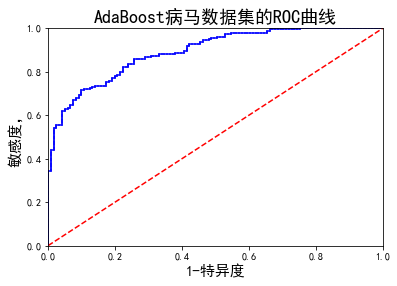

In [56]:
plotROC(xMat,yMat,40)

AUC面积

In [60]:
"""
函数功能：计算AUC面积
"""
def calAUC(xMat,yMat,maxC):
    cur = (1.0,1.0)         #初始化x，y起点
    ySum = 0                #初始化累积高度
    weakClass, aggClass = Ada_train(xMat,yMat,maxC)
    P = sum(yMat == 1)      #正样本个数
    yStep = 1/float(P)       #y轴步长
    xStep = 1/float(len(yMat) - P)   #x轴步长
    index = aggClass.T.argsort().tolist()[0]    #预测强度排序，返回的是索引
    for i in index:
        if yMat[i] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]                               #高度累加
        cur = (cur[0] - delX, cur[1] - delY)
    AUC = ySum *xStep
    print(f'AUC面积为：{round(AUC,2)}')
    return AUC

In [61]:
calAUC(xMat,yMat,maxC =10)

AUC面积为：0.86


0.8582969635063604